In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window

from gwpy.timeseries import TimeSeries

In [83]:
from gwpy.timeseries import TimeSeries

gps1=1267724179
gps2=1267724195
segment = (int(gps1), int(gps2))
print(segment)

from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
vdata = TimeSeries.fetch_open_data('V1', *segment, verbose=True)

(1267724179, 1267724195)
Fetched 1 URLs from gwosc.org for [1267724179 .. 1267724195))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1267724179 .. 1267724195))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1267724179 .. 1267724195))
Reading data... [Done]


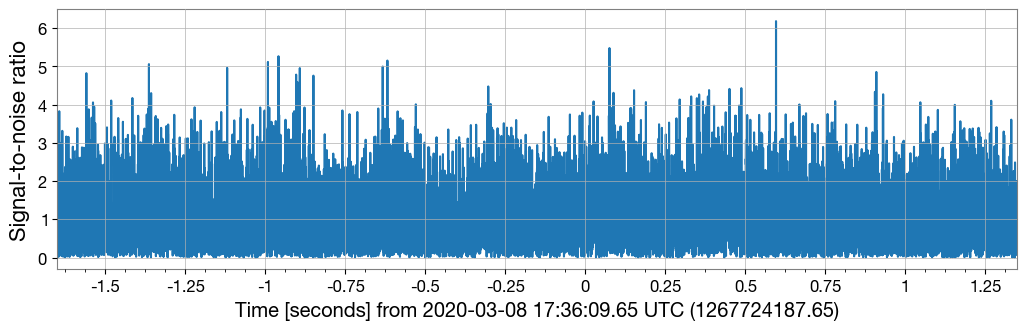

In [130]:
#ldata_white = ldata.whiten(fftlength=4,overlap=2,window=('tukey',1./4.))
#hdata_white = hdata.whiten(fftlength=4,overlap=2,window=('tukey',1./4.))
ldata_white = ldata.whiten(fftlength=4,overlap=2,window=('hann'))
hdata_white = hdata.whiten(fftlength=4,overlap=2,window=('hann'))
#mfilter = ldata_white.crop(gps1+8.5, gps1+9)
mfilter = ldata_white.crop(gps1+8.64, gps1+8.67)
snr = hdata_white.correlate(mfilter).abs()
plot = snr.crop(gps1+7, gps1+10).plot()
plot.axes[0].set_epoch(gps1+8.65)
plot.axes[0].set_ylabel('Signal-to-noise ratio', fontsize=16)
plot.show()

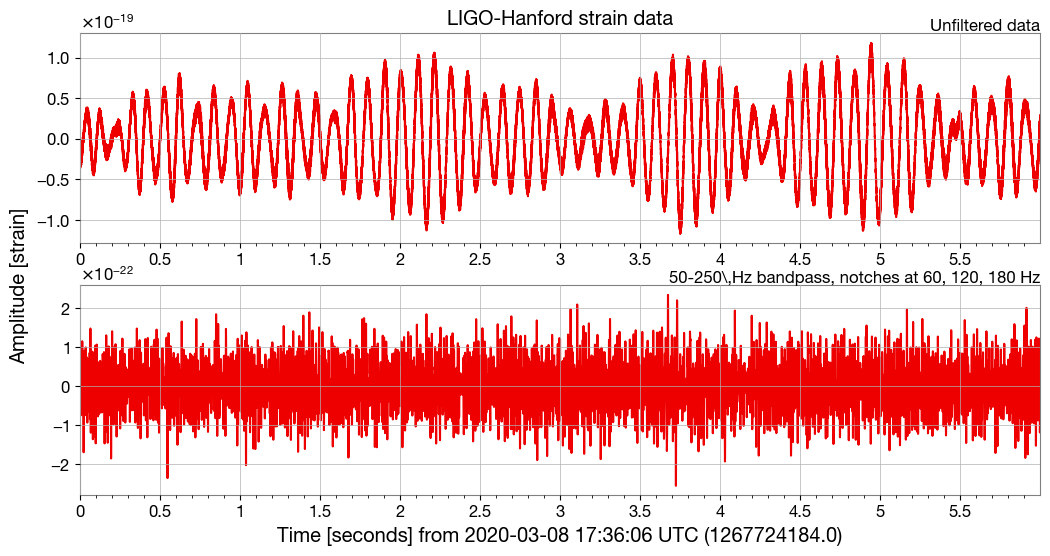

In [131]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate)
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]
zpk = filter_design.concatenate_zpks(bp, *notches)
hfilt = hdata.filter(zpk, filtfilt=True)
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

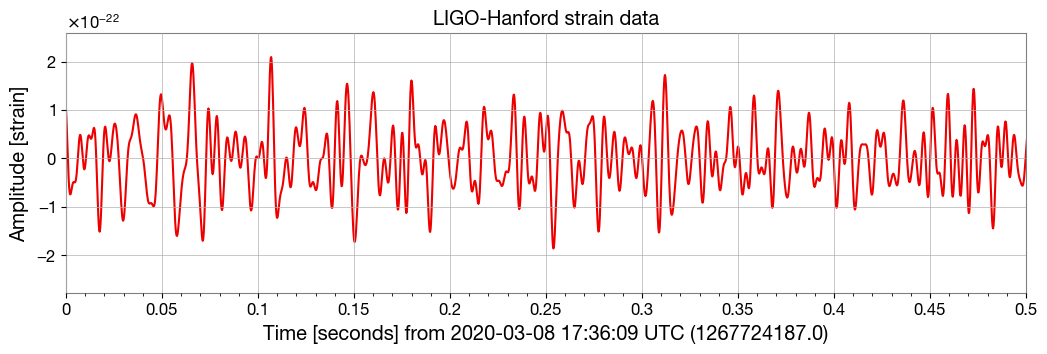

In [132]:
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(gps1+8,gps1+8.5)
ax.set_xscale('seconds', epoch=gps1+8)
plot.show()

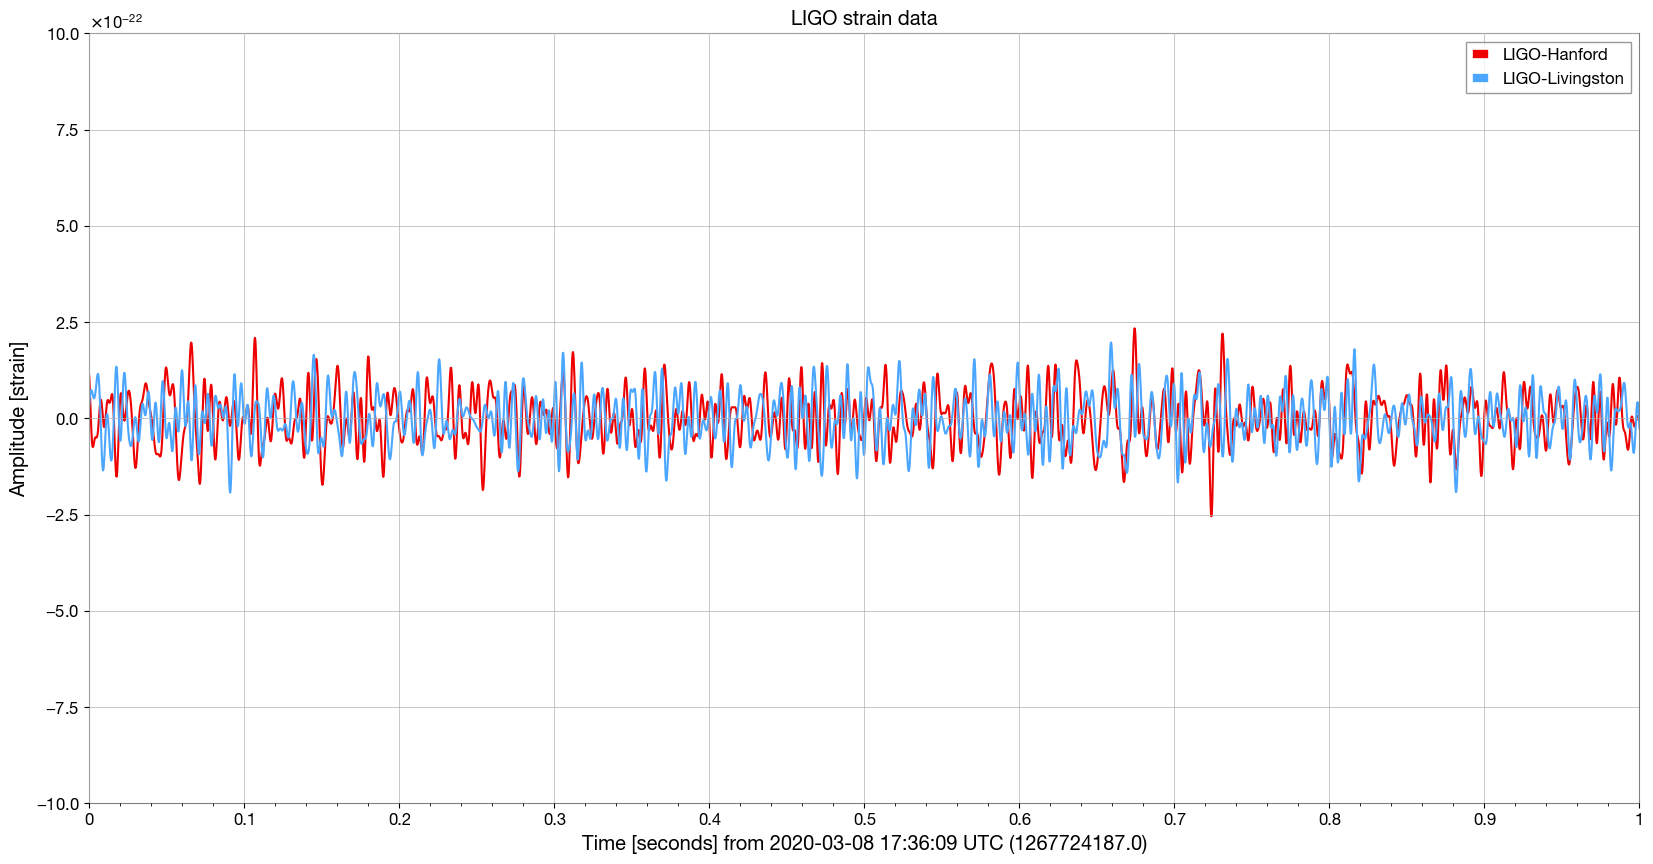

In [133]:
lfilt = ldata.filter(zpk, filtfilt=True)
lfilt.shift('2.5ms')
lfilt *= -1
plot = Plot(figsize=[20, 10])
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data')
ax.set_xlim(gps1+8,gps1+9)
ax.set_xscale('seconds', epoch=gps1+8)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()

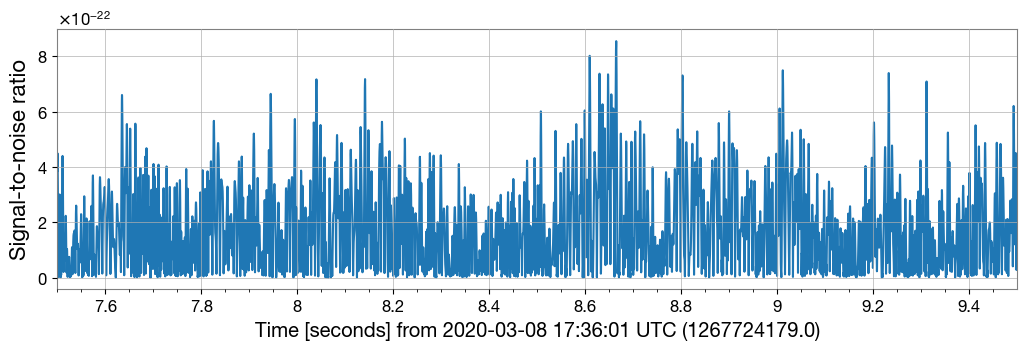

In [134]:
mfilter = lfilt.crop(gps1+8.6, gps1+8.7)

snr = hfilt.correlate(mfilter).abs()

plot = snr.crop(gps1+7.5, gps1+9.5).plot()
plot.axes[0].set_epoch(gps1)
plot.axes[0].set_ylabel('Signal-to-noise ratio', fontsize=16)
plot.show()

In [135]:
from gwpy.timeseries import TimeSeries
data = TimeSeries.fetch_open_data('H1', gps1, gps2)
high = data.highpass(15)
psd = high.psd(4, 2)
zoom = high.crop(gps1+6, gps2-6)
from pycbc.waveform import get_fd_waveform
hp, _ = get_fd_waveform(approximant="IMRPhenomD", mass1=60, mass2=24,
                        f_lower=20, f_final=2048, delta_f=psd.df.value)
from pycbc.filter import matched_filter
snr = matched_filter(hp, zoom.to_pycbc(), psd=psd.to_pycbc(),
                     low_frequency_cutoff=15)


/Users/noelsajenmathewsajanmathew/anaconda3/envs/cwb/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


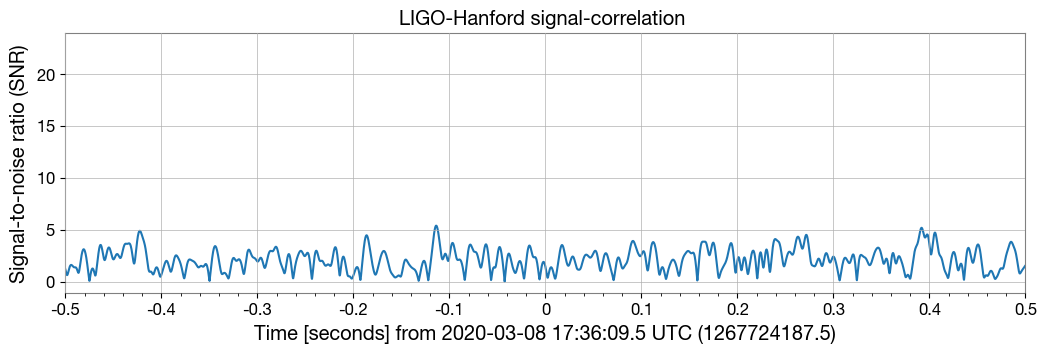

In [138]:
snrts = TimeSeries.from_pycbc(snr).abs()
plot
plot = snrts.plot()
ax = plot.gca()
ax.set_xlim(gps1+8, gps1+9)
ax.set_epoch(gps1+8.5)
ax.set_ylabel('Signal-to-noise ratio (SNR)')
ax.set_title('LIGO-Hanford signal-correlation ')
plot.show()

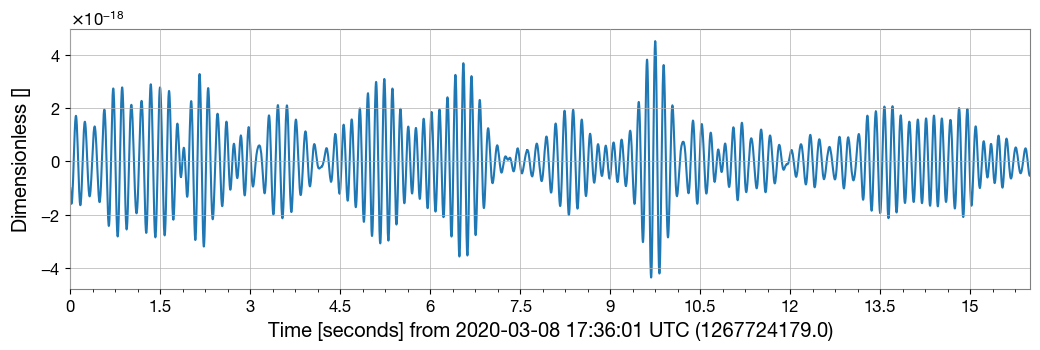

In [90]:
plot = ldata.plot()

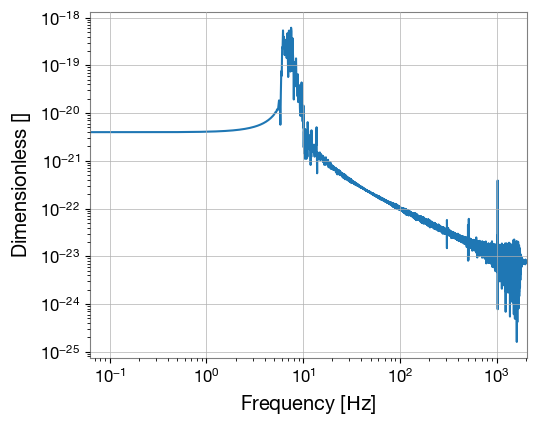

In [73]:
fft = ldata.fft()
plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False)

In [74]:
from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window

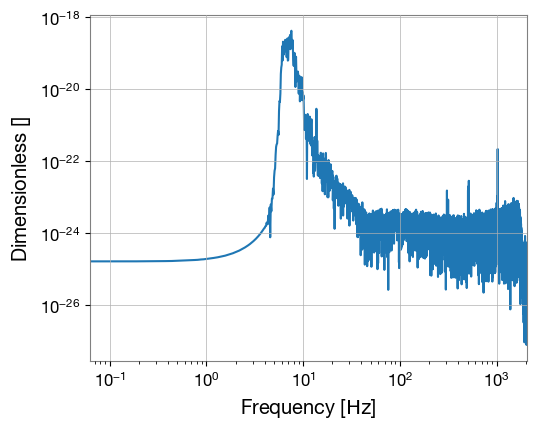

In [75]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

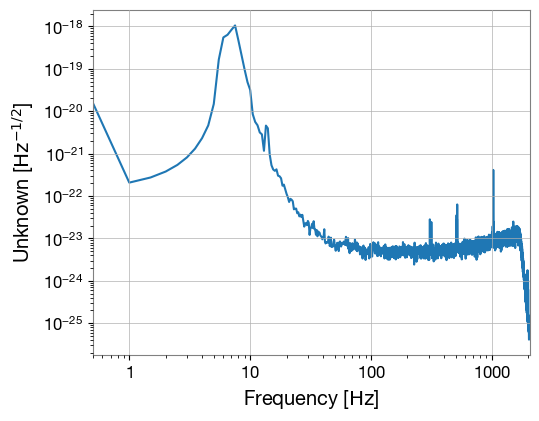

In [76]:
asd = ldata.asd(fftlength=2, method="median")
plot = asd.plot()
plot.show(warn=False)

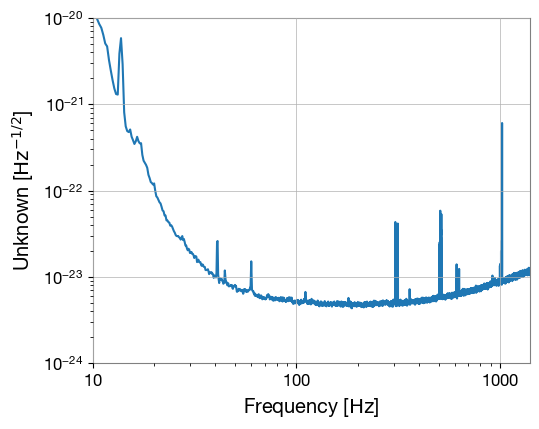

In [77]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps1)-512, int(gps2)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot.show(warn=False)

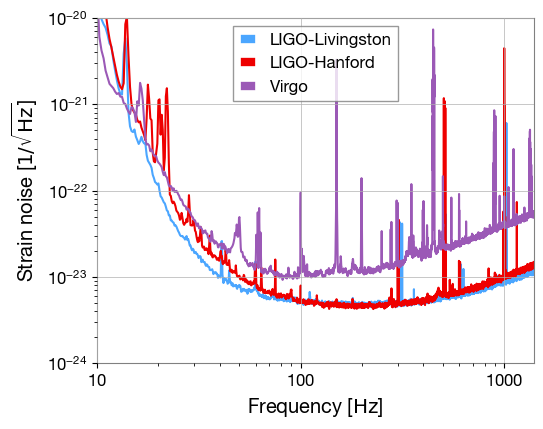

In [78]:

# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps1)-512, int(gps2)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# get Virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps1)-512, int(gps2)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

In [79]:
import gwpy

ValueError: Cannot determine mappable layer on any axes for this colorbar

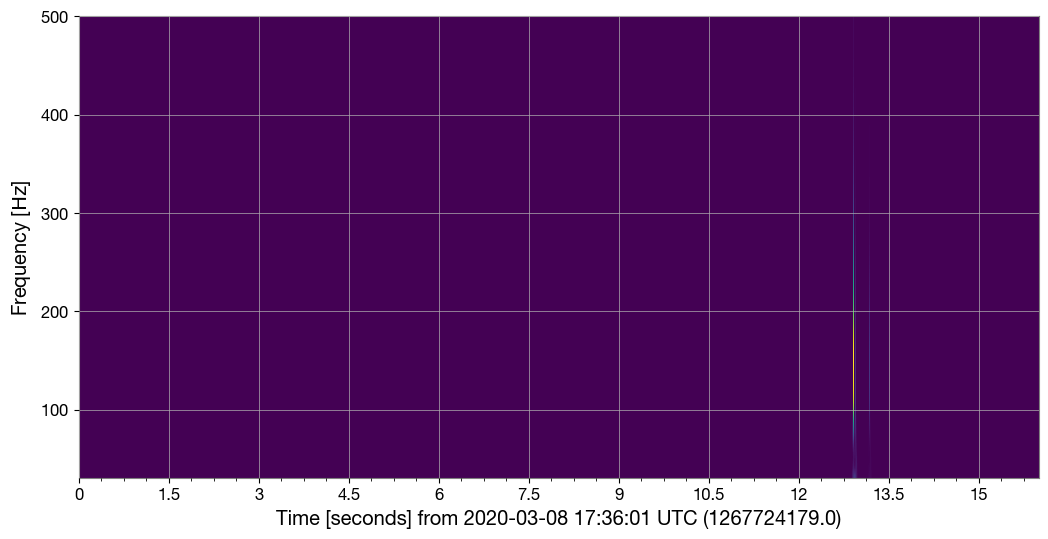

In [104]:
lq = ldata.q_transform(frange=(30, 500))
lplot = lq.plot()
plot.colorbar(label="Normalised energy")

hq = hdata.q_transform(frange=(30, 500))
hplot = hq.plot()
plot.colorbar(label="Normalised energy")

vq = vdata.q_transform(frange=(30, 500))
vplot = lq.plot()
plot.colorbar(label="Normalised energy")

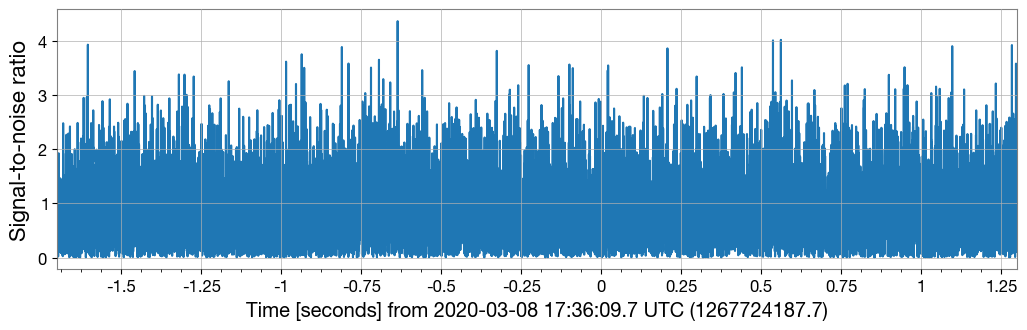

In [105]:
ax = lplot.gca()
ax.set_epoch(gps1+8.7)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot  # refresh

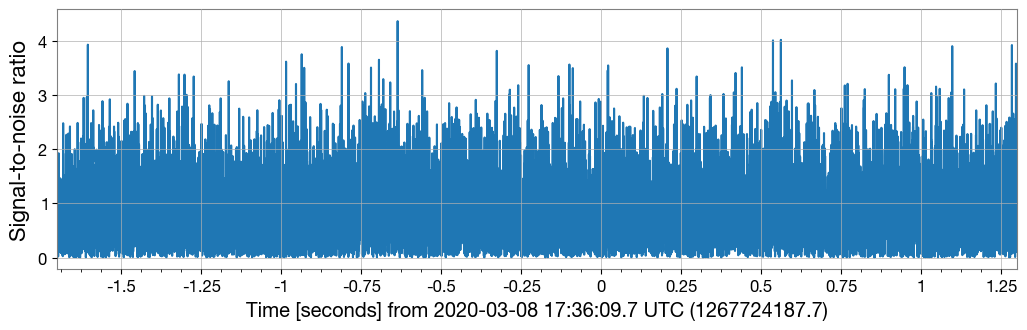

In [106]:
ax = hplot.gca()
ax.set_epoch(gps1)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot  # refresh

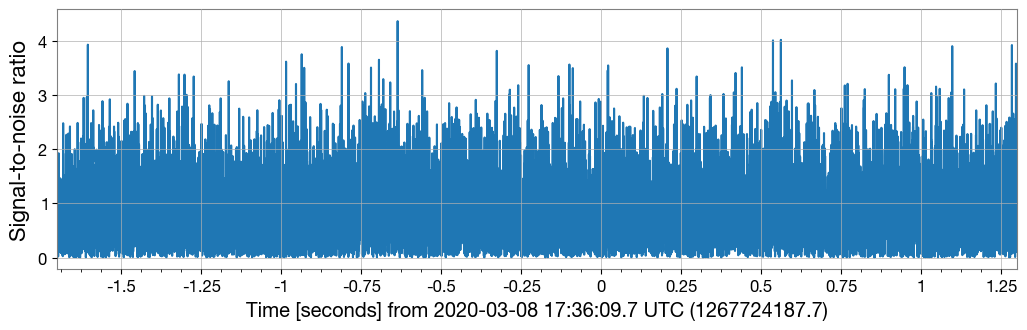

In [107]:
ax = vplot.gca()
ax.set_epoch(gps1)
ax.set_ylim(30, 500)
ax.set_yscale("log")
plot  # refresh

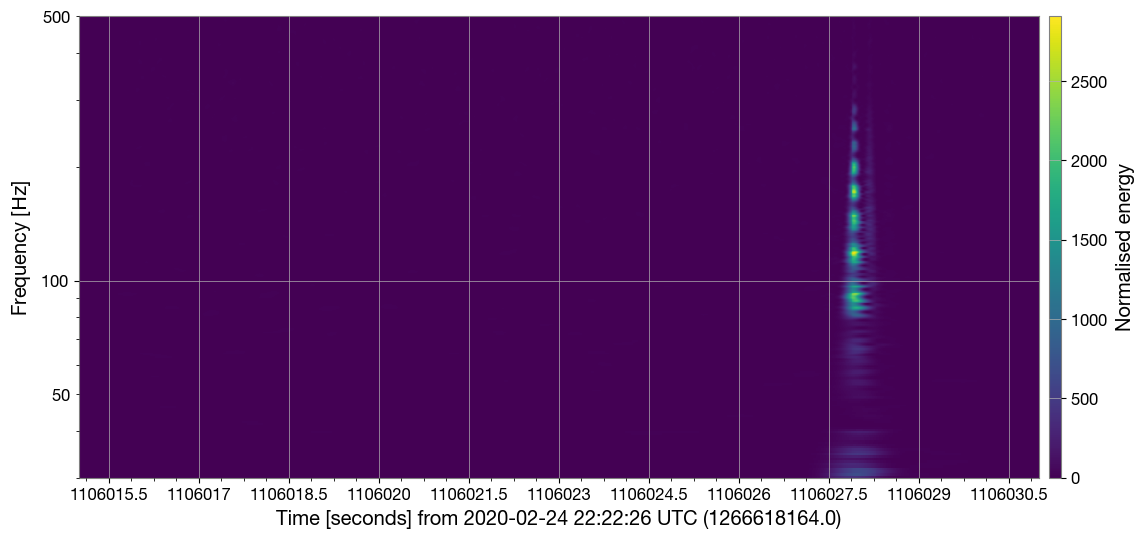

In [108]:
lq = ldata.q_transform(frange=(30, 500), qrange=(100, 110))
plot = lq.plot()
ax = plot.gca()
ax.set_epoch(gps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

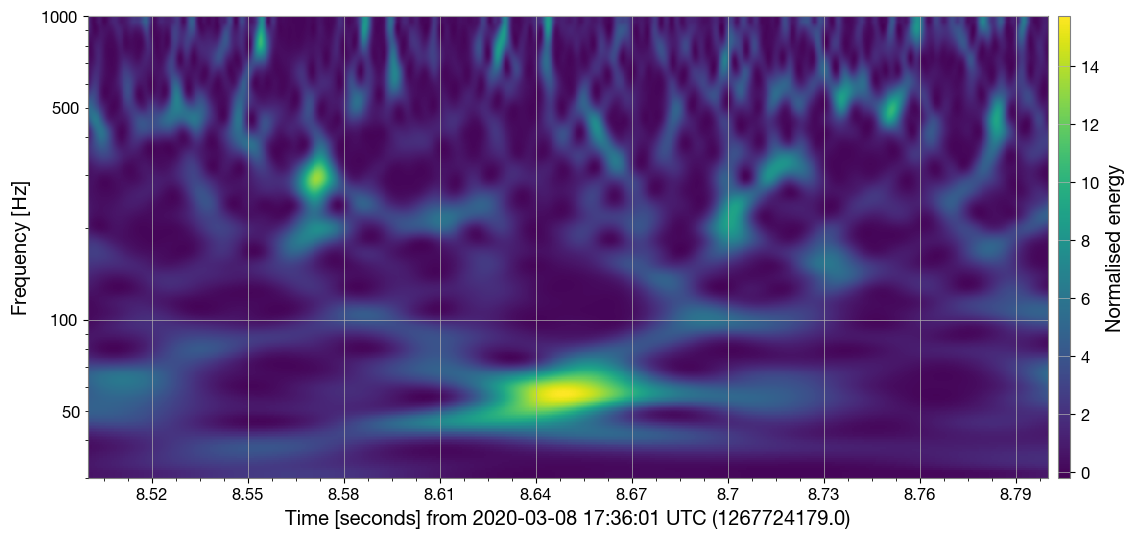

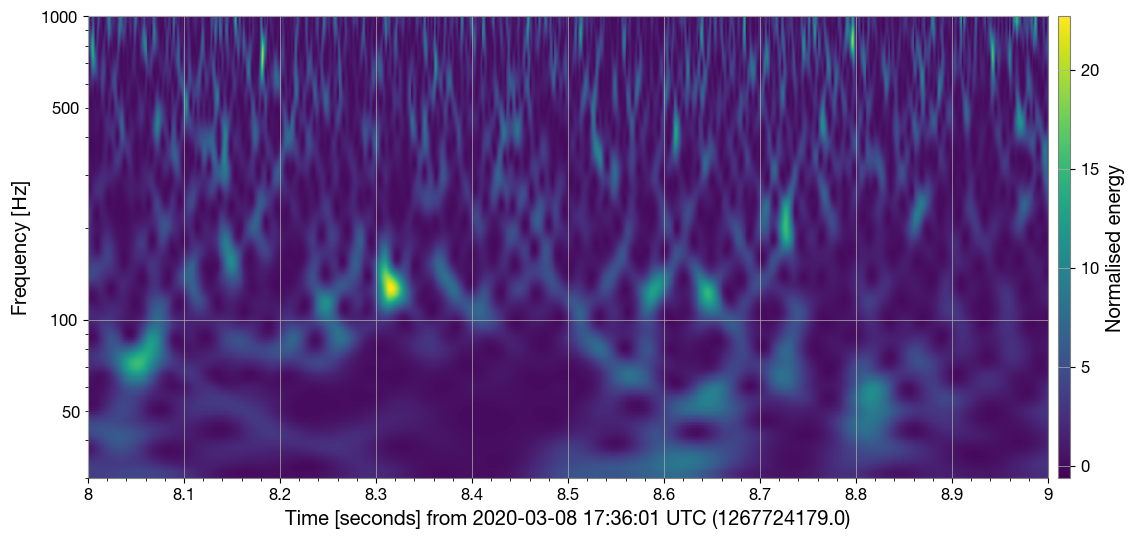

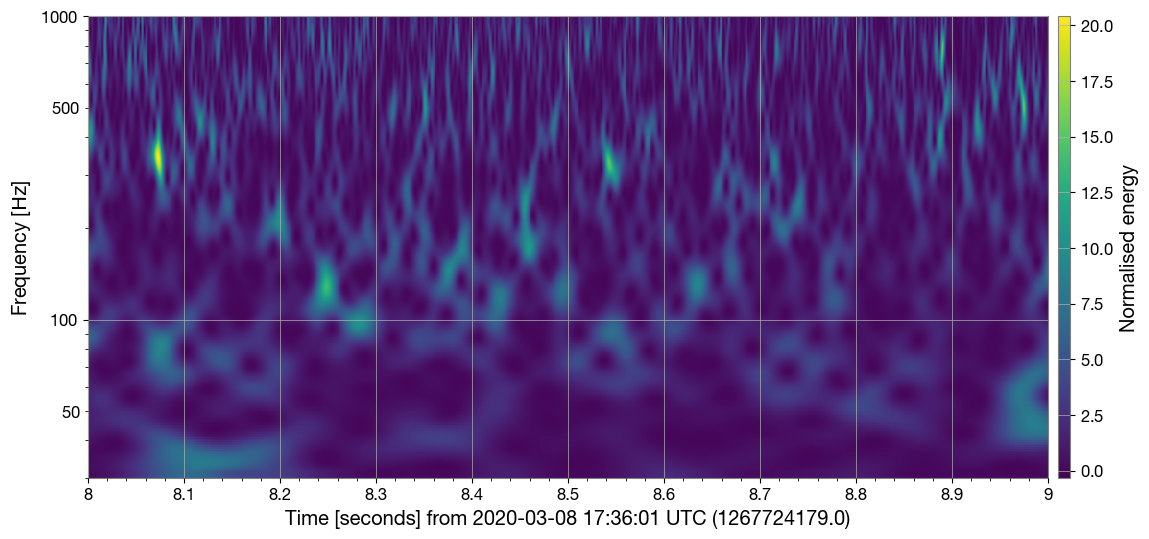

In [122]:
#-- Use OUTSEG for small time range
lq = ldata.q_transform(frange=(30, 1000), qrange=(10, 12), outseg=(gps1+8.5,gps1+8.8)) 
plot = lq.plot()
ax = plot.gca()
ax.set_epoch(gps1)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

hq = hdata.q_transform(frange=(30, 1000), qrange=(10, 12), outseg=(gps1+8,gps1+9)) 
plot = hq.plot()
ax = plot.gca()
ax.set_epoch(gps1)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

vq = vdata.q_transform(frange=(30, 1000), qrange=(10, 12), outseg=(gps1+8,gps1+9)) 
plot = vq.plot()
ax = plot.gca()
ax.set_epoch(gps1)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

In [ ]:
segment = (int(gps1), int(gps2))
print(segment)

from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
vdata = TimeSeries.fetch_open_data('V1', *segment, verbose=True)

(1267724179, 1267724195)
Fetched 1 URLs from gwosc.org for [1267724179 .. 1267724195))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1267724179 .. 1267724195))
Reading data... [Done]
Fetched 1 URLs from gwosc.org for [1267724179 .. 1267724195))
Reading data... [Done]


In [ ]:
ldata1 = ldata.whiten(16, 4)
hdata1 = hdata.whiten(16, 4)
vdata1 = vdata.whiten(16, 4)

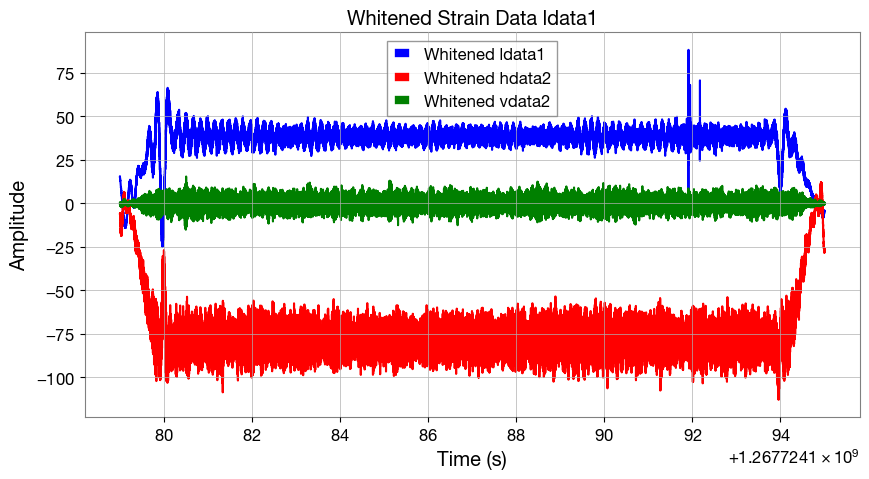

In [ ]:
import pylab

# Assuming ldata1 and hdata2 are whitened strain data TimeSeries objects

# Plot whitened ldata1
pylab.figure(figsize=[10, 5])
pylab.plot(ldata1.times, ldata1, label='Whitened ldata1', color='blue')
pylab.xlabel('Time (s)')
pylab.ylabel('Amplitude')
pylab.title('Whitened Strain Data ldata1')
pylab.legend()
pylab.grid(True)

# Plot whitened hdata2 on the same graph
pylab.plot(hdata1.times, hdata1, label='Whitened hdata2', color='red')
pylab.plot(vdata1.times, vdata1, label='Whitened vdata2', color='green')
pylab.legend()

pylab.show()

/Users/noelsajenmathewsajanmathew/anaconda3/envs/cwb/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


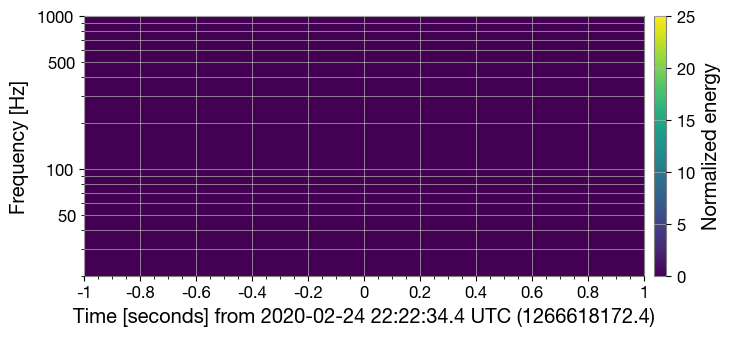

In [ ]:
qldata = ldata1.q_transform(
    whiten=False,  # already white
    qrange=(10, 12),  # wider Q-transform range
    outseg=(1266618171.4, 1266618173.4),  # region of interest
)
plot = qldata.imshow(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_epoch(1266618172.4)
ax.set_ylim(20, 1000)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy', clim=[0, 25])
plot.show()